In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import re
import operator
from pandas.core.common import flatten
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
#import pyhdb
from time import ctime

In [2]:
from datetime import datetime, timedelta
from collections import OrderedDict

In [3]:
from collections import Counter

In [4]:
df = pd.read_csv('C:/Users/rsure/Python Notebooks/LSTM note books/EY/Data Extraction/EY_FINAL_1.csv')
# df_2 = pd.read_csv('Query_Owned_COMM_IOT_Switching.csv')
# df_3 = pd.read_csv('Query_Owned_PUBLIC_SECTOR_IOT_Switching.csv')
# df_4 = pd.read_csv('Query_Owned_SMALL_IOT_Switching.csv')
# df_5 = pd.read_csv('Query_Owned_SERVICEPROVIDER_AND_OTHER_IOT_Switching.csv')

In [5]:
df.shape

(1943087, 20)

In [6]:
df['FISCAL_QUARTER_ID'].max()

20204

In [7]:
quarters =[20204]

In [8]:
df = df[~df['FISCAL_QUARTER_ID'].isin(quarters)]

In [9]:
df.shape

(1870031, 20)

In [10]:
df['ACTIVE_3YEARS'].describe()

count    1.870031e+06
mean     6.919797e-02
std      1.082836e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.333300e-02
max      1.000000e+00
Name: ACTIVE_3YEARS, dtype: float64

In [11]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [12]:
df.shape

(1870031, 19)

In [13]:
verts_train = df['SAVM_VERTICAL_MARKET_SEGMENT'].unique().tolist()
bes_train = df['BUSINESS_ENTITY'].unique().tolist()
scms_train = df['SAVM_SCMS_NAME'].unique().tolist()

In [14]:
df['SAVM_GROUP_ID'].nunique()

20010

Create Collab Revenue Feature 

In [15]:
df.SITES.describe()

count    1.870031e+06
mean     3.244493e+00
std      4.957895e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      2.160000e+02
Name: SITES, dtype: float64

In [16]:
df.head()

,SAVM_GROUP_ID,SAVM_SCMS_NAME,SAVM_VERTICAL_MARKET_SEGMENT,BUSINESS_ENTITY,FISCAL_QUARTER_ID,ACTUAL_BOOKINGS,LIST_PRICE,QUANTITY,EY_FLAG,TENURE,PENETRATION,CUMM_BOOK_SAVM,CUMM_BOOK_SAVM_ARC,AVG_REVENUE_VERT,DISCOUNT,AVG_QUR_BOOKINGS,SITES,ACTIVE_3YEARS,BOUGHT_EY_BEFORE
0,203686542,COMMERCIAL,Manufacturing,Computing Systems,20154,0,0,0,0,3,8,344409,0,401701,0.0,0,1,0.0,0
1,203686542,COMMERCIAL,Manufacturing,Other,20154,0,0,0,0,3,8,685288,0,401701,0.0,0,1,0.0,0
2,203686542,COMMERCIAL,Manufacturing,Other,20162,0,0,0,0,5,11,685288,0,302453,0.0,0,1,0.0,0
3,203686542,COMMERCIAL,Manufacturing,Services ASS_L1,20154,0,0,0,0,3,8,706082,0,401701,0.0,0,1,0.0,0
4,203687728,COMMERCIAL,Manufacturing,Data Center Networking,20141,0,0,0,0,0,0,180321,0,72389,0.0,0,1,0.0,0


In [17]:
df['BUSINESS_ENTITY'].unique()

array(['Computing Systems', 'Other', 'Services ASS_L1',
       'Data Center Networking', 'Enterprise Switching',
       'Service Provider Routing', 'Collaboration', 'IOT', 'Wireless',
       'Security', 'Enterprise Routing', 'Services TSS_L1', 'Meraki',
       'UNKNOWN', nan, 'SP Video Software and Solutions',
       'Monitoring and Analytics', 'SP Video Infrastructure'],
      dtype=object)

In [18]:
df_allrev_gb = df.groupby(['SAVM_GROUP_ID','FISCAL_QUARTER_ID'])['ACTUAL_BOOKINGS'].sum().reset_index()

In [19]:
df_colrev_gb = df[(df['BUSINESS_ENTITY']=='Computing Systems')| (df['BUSINESS_ENTITY']=='Data Center Networking')].groupby(['SAVM_GROUP_ID','FISCAL_QUARTER_ID'])['ACTUAL_BOOKINGS'].sum().reset_index()

In [20]:
df_colrev_gb.rename({'ACTUAL_BOOKINGS':'ACTUAL_BOOKINGS_COL'},axis=1,inplace=True)

In [21]:
df_colper = pd.merge(df_allrev_gb,df_colrev_gb,on=['SAVM_GROUP_ID','FISCAL_QUARTER_ID'])

In [22]:
df_colper['DataCenterRevenue'] = df_colper['ACTUAL_BOOKINGS_COL']/df_colper['ACTUAL_BOOKINGS']

In [23]:
df_colper.drop(['ACTUAL_BOOKINGS','ACTUAL_BOOKINGS_COL'],axis=1,inplace=True)

In [24]:
df = df.merge(df_colper,how='left',on=['SAVM_GROUP_ID','FISCAL_QUARTER_ID'])

In [25]:
df.head()

,SAVM_GROUP_ID,SAVM_SCMS_NAME,SAVM_VERTICAL_MARKET_SEGMENT,BUSINESS_ENTITY,FISCAL_QUARTER_ID,ACTUAL_BOOKINGS,LIST_PRICE,QUANTITY,EY_FLAG,TENURE,PENETRATION,CUMM_BOOK_SAVM,CUMM_BOOK_SAVM_ARC,AVG_REVENUE_VERT,DISCOUNT,AVG_QUR_BOOKINGS,SITES,ACTIVE_3YEARS,BOUGHT_EY_BEFORE,DataCenterRevenue
0,203686542,COMMERCIAL,Manufacturing,Computing Systems,20154,0,0,0,0,3,8,344409,0,401701,0.0,0,1,0.0,0,0.0
1,203686542,COMMERCIAL,Manufacturing,Other,20154,0,0,0,0,3,8,685288,0,401701,0.0,0,1,0.0,0,0.0
2,203686542,COMMERCIAL,Manufacturing,Other,20162,0,0,0,0,5,11,685288,0,302453,0.0,0,1,0.0,0,NaN
3,203686542,COMMERCIAL,Manufacturing,Services ASS_L1,20154,0,0,0,0,3,8,706082,0,401701,0.0,0,1,0.0,0,0.0
4,203687728,COMMERCIAL,Manufacturing,Data Center Networking,20141,0,0,0,0,0,0,180321,0,72389,0.0,0,1,0.0,0,0.0


In [26]:
df['DataCenterRevenue'].fillna(0,inplace=True)

End Feature creation

In [27]:
df[df['EY_FLAG']==1]['BUSINESS_ENTITY'].value_counts()

Collaboration               33205
Services TSS_L1             12179
Security                     3490
Wireless                     1358
Enterprise Routing           1311
Enterprise Switching          912
Data Center Networking        348
IOT                           185
Other                         176
Computing Systems             158
Services ASS_L1               146
UNKNOWN                       120
Monitoring and Analytics      113
Service Provider Routing       62
Meraki                         42
Name: BUSINESS_ENTITY, dtype: int64

In [28]:
savm_colab = df[((df['BUSINESS_ENTITY']=='Computing Systems') | (df['BUSINESS_ENTITY']=='Data Center Networking'))&(df['EY_FLAG']==1)]['SAVM_GROUP_ID'].tolist()

In [29]:
len(Counter(savm_colab).keys())

171

In [30]:
df.loc[df.SAVM_GROUP_ID.isin(savm_colab)].SAVM_GROUP_ID.nunique()

171

In [31]:
df_1 = df[~df.SAVM_GROUP_ID.isin(savm_colab)]

In [32]:
df_1[df_1['EY_FLAG']==1]['BUSINESS_ENTITY'].value_counts()

Collaboration               32748
Services TSS_L1             11529
Security                     3135
Wireless                     1073
Enterprise Routing           1065
Enterprise Switching          645
IOT                            92
Monitoring and Analytics       92
Services ASS_L1                55
Other                          54
UNKNOWN                        46
Meraki                         39
Name: BUSINESS_ENTITY, dtype: int64

In [33]:
df_1.shape

(1838211, 20)

In [34]:
df_1.head()

,SAVM_GROUP_ID,SAVM_SCMS_NAME,SAVM_VERTICAL_MARKET_SEGMENT,BUSINESS_ENTITY,FISCAL_QUARTER_ID,ACTUAL_BOOKINGS,LIST_PRICE,QUANTITY,EY_FLAG,TENURE,PENETRATION,CUMM_BOOK_SAVM,CUMM_BOOK_SAVM_ARC,AVG_REVENUE_VERT,DISCOUNT,AVG_QUR_BOOKINGS,SITES,ACTIVE_3YEARS,BOUGHT_EY_BEFORE,DataCenterRevenue
0,203686542,COMMERCIAL,Manufacturing,Computing Systems,20154,0,0,0,0,3,8,344409,0,401701,0.0,0,1,0.0,0,0.0
1,203686542,COMMERCIAL,Manufacturing,Other,20154,0,0,0,0,3,8,685288,0,401701,0.0,0,1,0.0,0,0.0
2,203686542,COMMERCIAL,Manufacturing,Other,20162,0,0,0,0,5,11,685288,0,302453,0.0,0,1,0.0,0,0.0
3,203686542,COMMERCIAL,Manufacturing,Services ASS_L1,20154,0,0,0,0,3,8,706082,0,401701,0.0,0,1,0.0,0,0.0
4,203687728,COMMERCIAL,Manufacturing,Data Center Networking,20141,0,0,0,0,0,0,180321,0,72389,0.0,0,1,0.0,0,0.0


In [35]:
df_1[((df_1['BUSINESS_ENTITY']=='Computing Systems') | (df_1['BUSINESS_ENTITY']=='Data Center Networking')) & (df_1['EY_FLAG']==1)].shape

(0, 20)

In [36]:
df_1['BUSINESS_ENTITY'] = np.where ( ((df_1['BUSINESS_ENTITY']=='Computing Systems') | (df_1['BUSINESS_ENTITY']=='Data Center Networking')) & (df_1['EY_FLAG']==1),'Reco_Prod',df_1['BUSINESS_ENTITY'])

In [37]:
df_1[(df_1['BUSINESS_ENTITY']=='Reco_Prod')].shape

(0, 20)

In [38]:
df_1.SAVM_GROUP_ID.nunique()

19839

In [ ]:
# df_1.drop(['ARCHITECTURE_BE'],axis=1,inplace=True)

In [39]:
def generate_security_revenue(row):
    if (row['BUSINESS_ENTITY'] == 'Computing Systems') | (row['BUSINESS_ENTITY'] == 'Data Center Networking') | (row['BUSINESS_ENTITY'] == 'Reco_Prod'):
        return row['ACTUAL_BOOKINGS']
    else :
        return 0

In [ ]:
# df_1['Colab_Revenue']=df_1.apply (lambda row: generate_security_revenue(row), axis=1)

In [40]:
def generate_cumilative_features(df_temp):
    df_temp['DataCenter_Revenue']=df_temp.apply (lambda row: generate_security_revenue(row), axis=1)
    df_temp_1=pd.DataFrame(df_temp.groupby(['SAVM_GROUP_ID','FISCAL_QUARTER_ID'])['DataCenter_Revenue'].sum()).reset_index()
    df_temp_1['DataCenter_Revenue_cumulative']=df_temp_1['DataCenter_Revenue'].cumsum()
    df_temp_1['Year']=df_temp_1['FISCAL_QUARTER_ID'].astype(str).str[:4]
    df_temp_2=pd.DataFrame(df_temp_1.groupby('Year')['DataCenter_Revenue'].sum()).reset_index()
    df_temp_2.columns=['Year','DataCenter_Revenue_cumulative_last_year']
    df_temp_2['DataCenter_Revenue_cumulative_last_year']=df_temp_2['DataCenter_Revenue_cumulative_last_year'].shift(1)
    df_temp_3=df_temp_1.merge(df_temp_2,on='Year',how='left')
    df_temp_3.drop(['DataCenter_Revenue','Year'],axis=1,inplace=True)
    df_temp_3['DataCenter_Revenue_cumulative_last_year'].fillna(0,inplace=True)
    df_final=df_temp.merge(df_temp_3,on=['SAVM_GROUP_ID','FISCAL_QUARTER_ID'],how='left')
    df_final.drop('DataCenter_Revenue',axis=1,inplace=True)
    return df_final

In [ ]:
# df_temp_1=pd.DataFrame(df_1.groupby(['SAVM_GROUP_ID','FISCAL_QUARTER_ID'])['Security_Revenue'].sum()).reset_index()
# df_temp_1['Security_Revenue_cumulative']=df_temp_1['Security_Revenue'].cumsum()
# df_temp_1['Year']=df_temp_1['FISCAL_QUARTER_ID'].astype(str).str[:4]
# df_temp_2=pd.DataFrame(df_temp_1.groupby('Year')['Security_Revenue'].sum()).reset_index()
# df_temp_2.columns=['Year','Security_Revenue_cumulative_last_year']
# df_temp_2['Security_Revenue_cumulative_last_year']=df_temp_2['Security_Revenue_cumulative_last_year'].shift(1)
# df_temp_3=df_temp_1.merge(df_temp_2,on='Year',how='left')
# df_temp_3.drop(['Security_Revenue','Year'],axis=1,inplace=True)
# df_temp_3['Security_Revenue_cumulative_last_year'].fillna(0,inplace=True)
# df_1=df_1.merge(df_temp_3,on=['SAVM_GROUP_ID','FISCAL_QUARTER_ID'],how='left')

In [ ]:
# df_1.drop('Security_Revenue',axis=1,inplace=True)

In [42]:
df_revised_new=df_1.groupby('SAVM_GROUP_ID').apply(lambda x: generate_cumilative_features(x))

In [43]:
df_revised_new.shape

(1838211, 22)

In [44]:
# df_revised.shape

In [45]:
df_1=df_revised_new

In [46]:
df_1.head()

SAVM_GROUP_ID SAVM_SCMS_NAME SAVM_VERTICAL_MARKET_SEGMENT  \
SAVM_GROUP_ID                                                                
203684844     0      203684844     COMMERCIAL             Energy/Utilities   
              1      203684844     COMMERCIAL             Energy/Utilities   
              2      203684844     COMMERCIAL             Energy/Utilities   
              3      203684844     COMMERCIAL             Energy/Utilities   
              4      203684844     COMMERCIAL             Energy/Utilities   

                      BUSINESS_ENTITY  FISCAL_QUARTER_ID  ACTUAL_BOOKINGS  \
SAVM_GROUP_ID                                                               
203684844     0         Collaboration              20181                0   
              1  Enterprise Switching              20203             2805   
              2    Enterprise Routing              20181             6290   
              3  Enterprise Switching              20181            12664   
              4                   IOT              20181            44870   

                 LIST_PRICE  QUANTITY  EY_FLAG  TENURE  ...  \
SAVM_GROUP_ID                                           ...   
203684844     0           0         0        0      12  ...   
              1           0         1        0      22  ...   
              2           0        10        0      12  ...   
              3           0         6        0      12  ...   
              4           0        41        0      12  ...   

                 CUMM_BOOK_SAVM_ARC  AVG_REVENUE_VERT  DISCOUNT  \
SAVM_GROUP_ID                                                     
203684844     0             1079996            396564       0.0   
              1              707504             52470   -2805.0   
              2              144345            396564   -6290.0   
              3              325926            396564  -12664.0   
              4              589003            396564  -44870.0   

                 AVG_QUR_BOOKINGS  SITES  ACTIVE_3YEARS  BOUGHT_EY_BEFORE  \
SAVM_GROUP_ID                                                               
203684844     0                 0      1       0.083333                 1   
              1               128      1       0.166666                 0   
              2               524      1       0.083333                 0   
              3              1055      1       0.083333                 0   
              4              3739      1       0.083333                 0   

                 DataCenterRevenue  DataCenter_Revenue_cumulative  \
SAVM_GROUP_ID                                                       
203684844     0                0.0                         123196   
              1                0.0                        1862232   
              2                0.0                         123196   
              3                0.0                         123196   
              4                0.0                         123196   

                 DataCenter_Revenue_cumulative_last_year  
SAVM_GROUP_ID                                             
203684844     0                                    354.0  
              1                                 240222.0  
              2                                    354.0  
              3                                    354.0  
              4                                    354.0  

[5 rows x 22 columns]

In [47]:
df_1.drop(['SAVM_GROUP_ID'],axis=1,inplace=True)

In [48]:
df_1.reset_index(inplace=True)

In [49]:
 df_1.drop('level_1',axis=1,inplace=True)

In [50]:
df_1.columns.tolist()

['SAVM_GROUP_ID',
 'SAVM_SCMS_NAME',
 'SAVM_VERTICAL_MARKET_SEGMENT',
 'BUSINESS_ENTITY',
 'FISCAL_QUARTER_ID',
 'ACTUAL_BOOKINGS',
 'LIST_PRICE',
 'QUANTITY',
 'EY_FLAG',
 'TENURE',
 'PENETRATION',
 'CUMM_BOOK_SAVM',
 'CUMM_BOOK_SAVM_ARC',
 'AVG_REVENUE_VERT',
 'DISCOUNT',
 'AVG_QUR_BOOKINGS',
 'SITES',
 'ACTIVE_3YEARS',
 'BOUGHT_EY_BEFORE',
 'DataCenterRevenue',
 'DataCenter_Revenue_cumulative',
 'DataCenter_Revenue_cumulative_last_year']

In [51]:
# df_1.loc[df_1.LIST_PRICE==0,'DISCOUNT']=0

In [52]:
df_1.SAVM_GROUP_ID.nunique()

19839

In [53]:
df_DataCenter_First = pd.DataFrame(df_1.loc[(df_1.BUSINESS_ENTITY=='Computing Systems')| (df_1.BUSINESS_ENTITY=='Data Center Networking') | (df_1.BUSINESS_ENTITY=='Reco_Prod'),:].groupby(['SAVM_GROUP_ID'])['TENURE'].min())

In [ ]:
#df_Security_First.SAVM_GROUP_ID.nunique()

In [54]:
df_DataCenter_First.reset_index(drop=False,inplace=True)

In [55]:
df_DataCenter_First.columns = ['SAVM_GROUP_ID','DataCenter_TENURE']

In [56]:
df_DataCenter_First.SAVM_GROUP_ID.nunique()

17534

In [57]:
df_1.shape

(1838211, 22)

In [59]:
df_1 = df_1.merge(df_DataCenter_First,on='SAVM_GROUP_ID',how='left')

In [60]:
df_1['DataCenter_TENURE'] = df_1['TENURE'] - df_1['DataCenter_TENURE']

In [62]:
df_1.loc[df_1.DataCenter_TENURE<=0,'DataCenter_TENURE'] = 0

In [65]:
df_1.loc[df_1.DataCenter_TENURE.isnull(),'DataCenter_TENURE']=0

In [66]:
df_1['SAVM_GROUP_ID'].nunique()

19839

In [67]:
verts_val = df_1['SAVM_VERTICAL_MARKET_SEGMENT'].unique().tolist()
bes_val = df_1['BUSINESS_ENTITY'].unique().tolist()
scms_val = df_1['SAVM_SCMS_NAME'].unique().tolist()

In [68]:
[i for i in verts_train if i not in verts_val]

[]

In [69]:
[i for i in bes_train if i not in bes_val]

[]

In [70]:
[i for i in scms_train if i not in scms_val]

[]

In [71]:
df_1.columns

Index(['SAVM_GROUP_ID', 'SAVM_SCMS_NAME', 'SAVM_VERTICAL_MARKET_SEGMENT',
       'BUSINESS_ENTITY', 'FISCAL_QUARTER_ID', 'ACTUAL_BOOKINGS', 'LIST_PRICE',
       'QUANTITY', 'EY_FLAG', 'TENURE', 'PENETRATION', 'CUMM_BOOK_SAVM',
       'CUMM_BOOK_SAVM_ARC', 'AVG_REVENUE_VERT', 'DISCOUNT',
       'AVG_QUR_BOOKINGS', 'SITES', 'ACTIVE_3YEARS', 'BOUGHT_EY_BEFORE',
       'DataCenterRevenue', 'DataCenter_Revenue_cumulative',
       'DataCenter_Revenue_cumulative_last_year', 'DataCenter_TENURE'],
      dtype='object')

In [72]:
df_1.columns=['SAVM_GROUP_ID', 'SAVM_SCMS_NAME',
       'SAVM_VERTICAL_MARKET_SEGMENT', 'BUSINESS_ENTITY', 'FISCAL_QUARTER_ID',
       'ACTUAL_BOOKINGS', 'LIST_PRICE', 'QUANTITY', 'EY_FLAG', 'TENURE',
       'PENETRATION', 'CUMM_BOOK_SAVM', 'CUMM_BOOK_SAVM_ARC',
       'AVG_REVENUE_VERT', 'DISCOUNT', 'AVG_QUR_BOOKINGS', 'SITES',
       'ACTIVE_3YEARS', 'BOUGHT_EY_BEFORE', 'DataCenterRevenue', 'DataCenter_Revenue_cumulative',
       'DataCenter_Revenue_cumulative_last_year', 'DataCenter_TENURE']

In [73]:
cat_columns = ['SAVM_VERTICAL_MARKET_SEGMENT','BUSINESS_ENTITY','SAVM_SCMS_NAME']
int_columns = ['SAVM_GROUP_ID', 'FISCAL_QUARTER_ID','ACTUAL_BOOKINGS','QUANTITY','TENURE','PENETRATION','CUMM_BOOK_SAVM',
               'CUMM_BOOK_SAVM_ARC','AVG_REVENUE_VERT','DISCOUNT',
       'AVG_QUR_BOOKINGS', 'SITES', 'ACTIVE_3YEARS', 'BOUGHT_EY_BEFORE',
       'DataCenterRevenue', 'DataCenter_Revenue_cumulative',
       'DataCenter_Revenue_cumulative_last_year', 'DataCenter_TENURE']

In [74]:
for column in df_1[cat_columns]:
    df_1[column].fillna(df_1[column].mode()[0], inplace=True)

In [75]:
for column in df_1[int_columns]:
    df_1[column].fillna(df_1[column].median(), inplace=True)

In [76]:
df_1.isnull().sum()

SAVM_GROUP_ID                              0
SAVM_SCMS_NAME                             0
SAVM_VERTICAL_MARKET_SEGMENT               0
BUSINESS_ENTITY                            0
FISCAL_QUARTER_ID                          0
ACTUAL_BOOKINGS                            0
LIST_PRICE                                 0
QUANTITY                                   0
EY_FLAG                                    0
TENURE                                     0
PENETRATION                                0
CUMM_BOOK_SAVM                             0
CUMM_BOOK_SAVM_ARC                         0
AVG_REVENUE_VERT                           0
DISCOUNT                                   0
AVG_QUR_BOOKINGS                           0
SITES                                      0
ACTIVE_3YEARS                              0
BOUGHT_EY_BEFORE                           0
DataCenterRevenue                          0
DataCenter_Revenue_cumulative              0
DataCenter_Revenue_cumulative_last_year    0
DataCenter

In [77]:
np.sort(df_1['FISCAL_QUARTER_ID'].unique())

array([20121, 20122, 20123, 20124, 20131, 20132, 20133, 20134, 20141,
       20142, 20143, 20144, 20151, 20152, 20153, 20154, 20161, 20162,
       20163, 20164, 20171, 20172, 20173, 20174, 20181, 20182, 20183,
       20184, 20191, 20192, 20193, 20194, 20201, 20202, 20203],
      dtype=int64)

In [78]:
#df_1.drop('SAVM_SCMS_NAME',axis=1,inplace=True)

In [79]:
#df_1.head()

In [80]:
df_1['FISCAL_QUARTER_ID'] = df_1['FISCAL_QUARTER_ID'].astype(str)
df_1['DT'] = df_1['FISCAL_QUARTER_ID'].str[0:4] +str(0)+df_1['FISCAL_QUARTER_ID'].str[4] 
df_1['DT'] = df_1['DT'].astype(int)
del df_1['FISCAL_QUARTER_ID']
df_1['year_quarter'] = df_1['DT']
del df_1['DT']

In [81]:
df_2 = df_1[['SAVM_GROUP_ID','year_quarter','BUSINESS_ENTITY','CUMM_BOOK_SAVM_ARC']]

In [82]:
df_temp=pd.DataFrame(df_1.loc[df_1.BUSINESS_ENTITY=='Reco_Prod'].groupby('year_quarter')['SAVM_GROUP_ID'].nunique()).reset_index()

In [83]:
df_temp.columns=['year_quarter','SAVM_count']

In [84]:
df_temp['year']=df_temp['year_quarter'].astype('str').str[:4]

In [85]:
df_temp_1=pd.DataFrame(df_temp.groupby('year')['SAVM_count'].sum()).reset_index()

In [86]:
df_temp_1['shifted_savm_count']=df_temp_1['SAVM_count'].shift(1)

In [87]:
df_temp_final=df_temp.merge(df_temp_1,on='year',how='left')

In [89]:
df_temp_final= pd.read_csv('datacenter_savm_count.csv')

In [90]:
df_temp_final.fillna(0,inplace=True)

In [91]:
df_temp_final.drop('Unnamed: 0',inplace=True,axis=1)

In [92]:
df_temp_final

,year,shifted_savm_count
0,2015,0.0
1,2016,2.0
2,2017,7.0
3,2018,21.0
4,2019,28.0
5,2020,57.0


In [93]:
df_temp_final.columns = ['Year','shifted_savm_count']

In [94]:
df_temp_final.dtypes

Year                    int64
shifted_savm_count    float64
dtype: object

In [95]:
df_1['Year'] = df_1['year_quarter'].apply(lambda x:str(x)[:4]).astype(int)

In [96]:
# df_1.drop('shifted_savm_count',axis=1,inplace=True)

In [97]:
df_1

,SAVM_GROUP_ID,SAVM_SCMS_NAME,SAVM_VERTICAL_MARKET_SEGMENT,BUSINESS_ENTITY,ACTUAL_BOOKINGS,LIST_PRICE,QUANTITY,EY_FLAG,TENURE,PENETRATION,...,AVG_QUR_BOOKINGS,SITES,ACTIVE_3YEARS,BOUGHT_EY_BEFORE,DataCenterRevenue,DataCenter_Revenue_cumulative,DataCenter_Revenue_cumulative_last_year,DataCenter_TENURE,year_quarter,Year
0,203684844,COMMERCIAL,Energy/Utilities,Collaboration,0,0,0,0,12,12,...,0,1,0.083333,1,0.000000,123196,354.0,12.0,201801,2018
1,203684844,COMMERCIAL,Energy/Utilities,Enterprise Switching,2805,0,1,0,22,12,...,128,1,0.166666,0,0.000000,1862232,240222.0,22.0,202003,2020
2,203684844,COMMERCIAL,Energy/Utilities,Enterprise Routing,6290,0,10,0,12,12,...,524,1,0.083333,0,0.000000,123196,354.0,12.0,201801,2018
3,203684844,COMMERCIAL,Energy/Utilities,Enterprise Switching,12664,0,6,0,12,12,...,1055,1,0.083333,0,0.000000,123196,354.0,12.0,201801,2018
4,203684844,COMMERCIAL,Energy/Utilities,IOT,44870,0,41,0,12,12,...,3739,1,0.083333,0,0.000000,123196,354.0,12.0,201801,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1838206,283606818,PUBLIC SECTOR,Unknown,Service Provider Routing,45878,281908,195,0,0,0,...,45878,3,0.083333,0,0.248127,264548,0.0,0.0,202003,2020
1838207,283606864,PUBLIC SECTOR,Education- Public/Private,Collaboration,4956,0,4,1,0,0,...,4956,1,0.083333,0,0.000000,0,0.0,0.0,202003,2020
1838208,283619180,SMALL,Unknown,Collaboration,5379,8535,43831,1,0,0,...,5379,1,0.083333,0,0.000000,0,0.0,0.0,202003,2020
1838209,283619180,SMALL,Unknown,Services ASS_L1,242,384,1,0,0,0,...,242,1,0.083333,0,0.000000,0,0.0,0.0,202003,2020


In [98]:
df_1_final=df_1.merge(df_temp_final,on='Year',how='left')

In [99]:
df_1_final.head()

,SAVM_GROUP_ID,SAVM_SCMS_NAME,SAVM_VERTICAL_MARKET_SEGMENT,BUSINESS_ENTITY,ACTUAL_BOOKINGS,LIST_PRICE,QUANTITY,EY_FLAG,TENURE,PENETRATION,...,SITES,ACTIVE_3YEARS,BOUGHT_EY_BEFORE,DataCenterRevenue,DataCenter_Revenue_cumulative,DataCenter_Revenue_cumulative_last_year,DataCenter_TENURE,year_quarter,Year,shifted_savm_count
0,203684844,COMMERCIAL,Energy/Utilities,Collaboration,0,0,0,0,12,12,...,1,0.083333,1,0.0,123196,354.0,12.0,201801,2018,21.0
1,203684844,COMMERCIAL,Energy/Utilities,Enterprise Switching,2805,0,1,0,22,12,...,1,0.166666,0,0.0,1862232,240222.0,22.0,202003,2020,57.0
2,203684844,COMMERCIAL,Energy/Utilities,Enterprise Routing,6290,0,10,0,12,12,...,1,0.083333,0,0.0,123196,354.0,12.0,201801,2018,21.0
3,203684844,COMMERCIAL,Energy/Utilities,Enterprise Switching,12664,0,6,0,12,12,...,1,0.083333,0,0.0,123196,354.0,12.0,201801,2018,21.0
4,203684844,COMMERCIAL,Energy/Utilities,IOT,44870,0,41,0,12,12,...,1,0.083333,0,0.0,123196,354.0,12.0,201801,2018,21.0


In [100]:
df_1_final['shifted_savm_count'].fillna(0,inplace=True)

In [101]:
df_1=df_1_final

In [102]:
df_1.head()

,SAVM_GROUP_ID,SAVM_SCMS_NAME,SAVM_VERTICAL_MARKET_SEGMENT,BUSINESS_ENTITY,ACTUAL_BOOKINGS,LIST_PRICE,QUANTITY,EY_FLAG,TENURE,PENETRATION,...,SITES,ACTIVE_3YEARS,BOUGHT_EY_BEFORE,DataCenterRevenue,DataCenter_Revenue_cumulative,DataCenter_Revenue_cumulative_last_year,DataCenter_TENURE,year_quarter,Year,shifted_savm_count
0,203684844,COMMERCIAL,Energy/Utilities,Collaboration,0,0,0,0,12,12,...,1,0.083333,1,0.0,123196,354.0,12.0,201801,2018,21.0
1,203684844,COMMERCIAL,Energy/Utilities,Enterprise Switching,2805,0,1,0,22,12,...,1,0.166666,0,0.0,1862232,240222.0,22.0,202003,2020,57.0
2,203684844,COMMERCIAL,Energy/Utilities,Enterprise Routing,6290,0,10,0,12,12,...,1,0.083333,0,0.0,123196,354.0,12.0,201801,2018,21.0
3,203684844,COMMERCIAL,Energy/Utilities,Enterprise Switching,12664,0,6,0,12,12,...,1,0.083333,0,0.0,123196,354.0,12.0,201801,2018,21.0
4,203684844,COMMERCIAL,Energy/Utilities,IOT,44870,0,41,0,12,12,...,1,0.083333,0,0.0,123196,354.0,12.0,201801,2018,21.0


In [103]:
df_dummified=pd.get_dummies(df_1,prefix=['Vert','BE','Seg'],columns=['SAVM_VERTICAL_MARKET_SEGMENT','BUSINESS_ENTITY','SAVM_SCMS_NAME'])

In [104]:
df_dummified.shape

(1838211, 60)

In [105]:
df_dummified['year_quarter'].unique()

array([201801, 202003, 201602, 201904, 201804, 201502, 201504, 201902,
       201803, 201604, 201901, 202001, 201702, 201802, 201703, 201704,
       201903, 202002, 201603, 201701, 201601, 201501, 201503, 201402,
       201404, 201401, 201403, 201303, 201304, 201301, 201302, 201204,
       201203, 201202, 201201], dtype=int64)

In [106]:
df_dummified.head()

,SAVM_GROUP_ID,ACTUAL_BOOKINGS,LIST_PRICE,QUANTITY,EY_FLAG,TENURE,PENETRATION,CUMM_BOOK_SAVM,CUMM_BOOK_SAVM_ARC,AVG_REVENUE_VERT,...,BE_Services ASS_L1,BE_Services TSS_L1,BE_UNKNOWN,BE_Wireless,Seg_COMMERCIAL,Seg_ENTERPRISE,Seg_OTHER,Seg_PUBLIC SECTOR,Seg_SERVICE PROVIDER,Seg_SMALL
0,203684844,0,0,0,0,12,12,1079996,1079996,396564,...,0,0,0,0,1,0,0,0,0,0
1,203684844,2805,0,1,0,22,12,4751712,707504,52470,...,0,0,0,0,1,0,0,0,0,0
2,203684844,6290,0,10,0,12,12,3882047,144345,396564,...,0,0,0,0,1,0,0,0,0,0
3,203684844,12664,0,6,0,12,12,4370134,325926,396564,...,0,0,0,0,1,0,0,0,0,0
4,203684844,44870,0,41,0,12,12,5413926,589003,396564,...,0,0,0,0,1,0,0,0,0,0


In [107]:
df_dummified.shape

(1838211, 60)

In [108]:
df_dummified.columns.tolist()

['SAVM_GROUP_ID',
 'ACTUAL_BOOKINGS',
 'LIST_PRICE',
 'QUANTITY',
 'EY_FLAG',
 'TENURE',
 'PENETRATION',
 'CUMM_BOOK_SAVM',
 'CUMM_BOOK_SAVM_ARC',
 'AVG_REVENUE_VERT',
 'DISCOUNT',
 'AVG_QUR_BOOKINGS',
 'SITES',
 'ACTIVE_3YEARS',
 'BOUGHT_EY_BEFORE',
 'DataCenterRevenue',
 'DataCenter_Revenue_cumulative',
 'DataCenter_Revenue_cumulative_last_year',
 'DataCenter_TENURE',
 'year_quarter',
 'Year',
 'shifted_savm_count',
 'Vert_Education- Public/Private',
 'Vert_Energy/Utilities',
 'Vert_Financial Services',
 'Vert_Government',
 'Vert_Health Care',
 'Vert_Hospitality/Hotels & Leisure',
 'Vert_Manufacturing',
 'Vert_Media/Entertainment',
 'Vert_Professional Services',
 'Vert_Retail',
 'Vert_Service Provider',
 'Vert_Technical Services',
 'Vert_Transportation',
 'Vert_Unknown',
 'Vert_Wholesale/Distribution',
 'BE_Collaboration',
 'BE_Computing Systems',
 'BE_Data Center Networking',
 'BE_Enterprise Routing',
 'BE_Enterprise Switching',
 'BE_IOT',
 'BE_Meraki',
 'BE_Monitoring and Analytics

In [109]:
df_dummified.drop('Seg_OTHER',axis=1,inplace=True)

In [110]:
df_dummified['Seg_SERVICE PROVIDER'] = df_dummified['Seg_SERVICE PROVIDER'] | df_dummified['Seg_SMALL']

In [111]:
#df_dummified.columns.tolist()

In [116]:
#pl_columns=[col for col in df_dummified if col.startswith('Prod_')]
#pl_columns = ['Prod_Reco_Prod']
vr_columns=[col for col in df_dummified if col.startswith('Vert_')]
be_columns=[col for col in df_dummified if col.startswith('BE_')]
scms_columns=[col for col in df_dummified if col.startswith('Seg_')]
numerical_columns =  ['TENURE','PENETRATION','CUMM_BOOK_SAVM','AVG_REVENUE_VERT',
                     'DISCOUNT',
                      'DataCenter_TENURE','AVG_QUR_BOOKINGS', 'SITES', 'ACTIVE_3YEARS', 'BOUGHT_EY_BEFORE','DataCenterRevenue', 'DataCenter_Revenue_cumulative',
       'DataCenter_Revenue_cumulative_last_year','shifted_savm_count']
sum_cols = ['ACTUAL_BOOKINGS','QUANTITY']

In [113]:
df_temp_1=df_dummified.groupby(['SAVM_GROUP_ID','year_quarter'])[vr_columns].apply(lambda x : x.astype(int).sum())

In [114]:
for column in df_temp_1.columns:
    df_temp_1[column]= np.where(df_temp_1[column]>0,1,0)

In [115]:
df_temp_2=df_dummified.groupby(['SAVM_GROUP_ID','year_quarter'])[be_columns].apply(lambda x : x.astype(int).sum())

In [117]:
for column in df_temp_2.columns:
    df_temp_2[column]= np.where(df_temp_2[column]>0,1,0)

In [118]:
df_temp_3 =  df_dummified.groupby(['SAVM_GROUP_ID','year_quarter'])[numerical_columns].max()
df_temp_4 =  df_dummified.groupby(['SAVM_GROUP_ID','year_quarter'])[sum_cols].sum()
df_temp_5=df_dummified.groupby(['SAVM_GROUP_ID','year_quarter'])[scms_columns].apply(lambda x : x.astype(int).sum())

In [119]:
for column in df_temp_5.columns:
    df_temp_5[column]= np.where(df_temp_5[column]>0,1,0)

In [120]:
df_aggregated=pd.concat([df_temp_1,df_temp_2,df_temp_3,df_temp_4,df_temp_5],axis=1)

In [121]:
df_aggregated.head()

Vert_Education- Public/Private  \
SAVM_GROUP_ID year_quarter                                   
203684844     201501                                     0   
              201502                                     0   
              201503                                     0   
              201504                                     0   
              201601                                     0   

                            Vert_Energy/Utilities  Vert_Financial Services  \
SAVM_GROUP_ID year_quarter                                                   
203684844     201501                            1                        0   
              201502                            1                        0   
              201503                            1                        0   
              201504                            1                        0   
              201601                            1                        0   

                            Vert_Government  Vert_Health Care  \
SAVM_GROUP_ID year_quarter                                      
203684844     201501                      0                 0   
              201502                      0                 0   
              201503                      0                 0   
              201504                      0                 0   
              201601                      0                 0   

                            Vert_Hospitality/Hotels & Leisure  \
SAVM_GROUP_ID year_quarter                                      
203684844     201501                                        0   
              201502                                        0   
              201503                                        0   
              201504                                        0   
              201601                                        0   

                            Vert_Manufacturing  Vert_Media/Entertainment  \
SAVM_GROUP_ID year_quarter                                                 
203684844     201501                         0                         0   
              201502                         0                         0   
              201503                         0                         0   
              201504                         0                         0   
              201601                         0                         0   

                            Vert_Professional Services  Vert_Retail  ...  \
SAVM_GROUP_ID year_quarter                                           ...   
203684844     201501                                 0            0  ...   
              201502                                 0            0  ...   
              201503                                 0            0  ...   
              201504                                 0            0  ...   
              201601                                 0            0  ...   

                            DataCenter_Revenue_cumulative  \
SAVM_GROUP_ID year_quarter                                  
203684844     201501                                38090   
              201502                                55237   
              201503                                55838   
              201504                                94746   
              201601                                98957   

                            DataCenter_Revenue_cumulative_last_year  \
SAVM_GROUP_ID year_quarter                                            
203684844     201501                                            0.0   
              201502                                            0.0   
              201503                                            0.0   
              201504                                            0.0   
              201601                                        94746.0   

                            shifted_savm_count  ACTUAL_BOOKINGS  QUANTITY  \
SAVM_GROUP_ID year_quarter                                       

In [122]:
df_aggregated.reset_index(inplace=True)

In [123]:
df_aggregated.head()

,SAVM_GROUP_ID,year_quarter,Vert_Education- Public/Private,Vert_Energy/Utilities,Vert_Financial Services,Vert_Government,Vert_Health Care,Vert_Hospitality/Hotels & Leisure,Vert_Manufacturing,Vert_Media/Entertainment,...,DataCenter_Revenue_cumulative,DataCenter_Revenue_cumulative_last_year,shifted_savm_count,ACTUAL_BOOKINGS,QUANTITY,Seg_COMMERCIAL,Seg_ENTERPRISE,Seg_PUBLIC SECTOR,Seg_SERVICE PROVIDER,Seg_SMALL
0,203684844,201501,0,1,0,0,0,0,0,0,...,38090,0.0,0.0,755696,7375,1,0,0,0,0
1,203684844,201502,0,1,0,0,0,0,0,0,...,55237,0.0,0.0,80904,208,1,0,0,0,0
2,203684844,201503,0,1,0,0,0,0,0,0,...,55838,0.0,0.0,42182,181,1,0,0,0,0
3,203684844,201504,0,1,0,0,0,0,0,0,...,94746,0.0,0.0,91929,398,1,0,0,0,0
4,203684844,201601,0,1,0,0,0,0,0,0,...,98957,94746.0,2.0,381727,387361,1,0,0,0,0


In [124]:
df_aggregated.shape

(338930, 55)

In [125]:
df_aggregated.SAVM_GROUP_ID.nunique()

19839

In [126]:
df_2.head()

,SAVM_GROUP_ID,year_quarter,BUSINESS_ENTITY,CUMM_BOOK_SAVM_ARC
0,203684844,201801,Collaboration,1079996
1,203684844,202003,Enterprise Switching,707504
2,203684844,201801,Enterprise Routing,144345
3,203684844,201801,Enterprise Switching,325926
4,203684844,201801,IOT,589003


In [127]:
df2_pivot = df_2.pivot_table(values='CUMM_BOOK_SAVM_ARC',index=['SAVM_GROUP_ID', 'year_quarter'],
                 columns='BUSINESS_ENTITY',aggfunc=np.max).add_prefix('BEval_').reset_index()

In [128]:
df2_pivot.fillna(0,inplace=True)

In [129]:
df2_pivot.head()

BUSINESS_ENTITY,SAVM_GROUP_ID,year_quarter,BEval_Collaboration,BEval_Computing Systems,BEval_Data Center Networking,BEval_Enterprise Routing,BEval_Enterprise Switching,BEval_IOT,BEval_Meraki,BEval_Monitoring and Analytics,BEval_Other,BEval_SP Video Infrastructure,BEval_SP Video Software and Solutions,BEval_Security,BEval_Service Provider Routing,BEval_Services ASS_L1,BEval_Services TSS_L1,BEval_UNKNOWN,BEval_Wireless
0,203684844,201501,119334.0,0.0,38090.0,25311.0,189854.0,75843.0,0.0,0.0,0.0,0.0,0.0,95778.0,6156.0,0.0,194914.0,0.0,10661.0
1,203684844,201502,128078.0,0.0,55266.0,30152.0,202279.0,92918.0,0.0,0.0,0.0,0.0,0.0,115130.0,7989.0,0.0,196743.0,0.0,10546.0
2,203684844,201503,130596.0,0.0,55838.0,34719.0,208203.0,119178.0,0.0,0.0,0.0,0.0,0.0,0.0,9015.0,0.0,195766.0,0.0,0.0
3,203684844,201504,139812.0,0.0,94746.0,41119.0,212030.0,151230.0,0.0,0.0,0.0,0.0,0.0,115106.0,9699.0,0.0,196425.0,0.0,0.0
4,203684844,201601,216952.0,0.0,98957.0,48927.0,227896.0,190260.0,0.0,0.0,640.0,0.0,0.0,0.0,12337.0,0.0,384767.0,921.0,55731.0


In [130]:
df2_pivot.shape

(338930, 19)

In [131]:
df_aggregated_1 = pd.merge(df_aggregated,df2_pivot,on=['SAVM_GROUP_ID','year_quarter'])

In [132]:
df_aggregated_1.columns.tolist()

['SAVM_GROUP_ID',
 'year_quarter',
 'Vert_Education- Public/Private',
 'Vert_Energy/Utilities',
 'Vert_Financial Services',
 'Vert_Government',
 'Vert_Health Care',
 'Vert_Hospitality/Hotels & Leisure',
 'Vert_Manufacturing',
 'Vert_Media/Entertainment',
 'Vert_Professional Services',
 'Vert_Retail',
 'Vert_Service Provider',
 'Vert_Technical Services',
 'Vert_Transportation',
 'Vert_Unknown',
 'Vert_Wholesale/Distribution',
 'BE_Collaboration',
 'BE_Computing Systems',
 'BE_Data Center Networking',
 'BE_Enterprise Routing',
 'BE_Enterprise Switching',
 'BE_IOT',
 'BE_Meraki',
 'BE_Monitoring and Analytics',
 'BE_Other',
 'BE_SP Video Infrastructure',
 'BE_SP Video Software and Solutions',
 'BE_Security',
 'BE_Service Provider Routing',
 'BE_Services ASS_L1',
 'BE_Services TSS_L1',
 'BE_UNKNOWN',
 'BE_Wireless',
 'TENURE',
 'PENETRATION',
 'CUMM_BOOK_SAVM',
 'AVG_REVENUE_VERT',
 'DISCOUNT',
 'DataCenter_TENURE',
 'AVG_QUR_BOOKINGS',
 'SITES',
 'ACTIVE_3YEARS',
 'BOUGHT_EY_BEFORE',
 'Da

In [133]:
#df_aggregated_1.drop('BEval_Reco_Prod',axis=1,inplace=True)

In [134]:
df_aggregated_1.head()


,SAVM_GROUP_ID,year_quarter,Vert_Education- Public/Private,Vert_Energy/Utilities,Vert_Financial Services,Vert_Government,Vert_Health Care,Vert_Hospitality/Hotels & Leisure,Vert_Manufacturing,Vert_Media/Entertainment,...,BEval_Monitoring and Analytics,BEval_Other,BEval_SP Video Infrastructure,BEval_SP Video Software and Solutions,BEval_Security,BEval_Service Provider Routing,BEval_Services ASS_L1,BEval_Services TSS_L1,BEval_UNKNOWN,BEval_Wireless
0,203684844,201501,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,95778.0,6156.0,0.0,194914.0,0.0,10661.0
1,203684844,201502,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,115130.0,7989.0,0.0,196743.0,0.0,10546.0
2,203684844,201503,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,9015.0,0.0,195766.0,0.0,0.0
3,203684844,201504,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,115106.0,9699.0,0.0,196425.0,0.0,0.0
4,203684844,201601,0,1,0,0,0,0,0,0,...,0.0,640.0,0.0,0.0,0.0,12337.0,0.0,384767.0,921.0,55731.0


In [135]:
df_aggregated_final=df_aggregated_1.groupby(['SAVM_GROUP_ID']).apply(lambda x: x.sort_values('year_quarter',ascending=True))

In [136]:
df_aggregated_final.reset_index(inplace=True,drop=True)

In [137]:
df_aggregated_final.shape

(338930, 72)

In [138]:
def insert_rows(data):
    a = data.year_quarter.unique()
    b = data.SAVM_GROUP_ID.unique()
    dt1 = pd.MultiIndex.from_product([b,a ]).to_frame(index=False, name=['SAVM_GROUP_ID','year_quarter'])
    dt2 = dt1.merge(data.groupby('SAVM_GROUP_ID').agg({'year_quarter':'min'}).reset_index(),how = 'left',on='SAVM_GROUP_ID')
    dt3 = dt2[dt2.year_quarter_x >=dt2.year_quarter_y][['SAVM_GROUP_ID','year_quarter_x']]
    dt4 = dt3.merge(data.groupby('SAVM_GROUP_ID').agg({'year_quarter':'max'}).reset_index(),how = 'left',on='SAVM_GROUP_ID')
    dt5 = dt4[dt4.year_quarter_x <=dt4.year_quarter][['SAVM_GROUP_ID','year_quarter_x']]
    dt5.columns = ['SAVM_GROUP_ID','year_quarter']
    dt = dt5.merge(data,how='left',on=['SAVM_GROUP_ID','year_quarter'])
    dt = dt.sort_values(['SAVM_GROUP_ID','year_quarter'], axis = 0, ascending = True) 
    dt = dt.fillna(0)
    return dt

In [139]:
df_aggregated_inserted = insert_rows(df_aggregated_final)

In [140]:
#df_aggregated_inserted.SAV

In [141]:
#df_aggregated_inserted.drop('SAVM_GROUP_ID',axis=1,inplace=True)

In [142]:
df_aggregated_inserted.shape

(386005, 72)

In [143]:
df_aggregated_inserted.SAVM_GROUP_ID.nunique()

19839

In [144]:
# df_aggregated_inserted.reset_index(inplace=True)

In [145]:
df_aggregated_inserted.head()

,SAVM_GROUP_ID,year_quarter,Vert_Education- Public/Private,Vert_Energy/Utilities,Vert_Financial Services,Vert_Government,Vert_Health Care,Vert_Hospitality/Hotels & Leisure,Vert_Manufacturing,Vert_Media/Entertainment,...,BEval_Monitoring and Analytics,BEval_Other,BEval_SP Video Infrastructure,BEval_SP Video Software and Solutions,BEval_Security,BEval_Service Provider Routing,BEval_Services ASS_L1,BEval_Services TSS_L1,BEval_UNKNOWN,BEval_Wireless
0,203684844,201501,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,95778.0,6156.0,0.0,194914.0,0.0,10661.0
1,203684844,201502,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,115130.0,7989.0,0.0,196743.0,0.0,10546.0
2,203684844,201503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9015.0,0.0,195766.0,0.0,0.0
3,203684844,201504,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,115106.0,9699.0,0.0,196425.0,0.0,0.0
4,203684844,201601,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,640.0,0.0,0.0,0.0,12337.0,0.0,384767.0,921.0,55731.0


In [146]:
df_aggregated_inserted['BE_Reco_Prod']= 0

In [147]:
beval_columns=[col for col in df_aggregated_inserted if col.startswith('BEval_')]

In [148]:
# df_aggregated_inserted.columns.tolist()

In [149]:
df_aggregated_inserted['Rank_'] = df_aggregated_inserted.groupby(['SAVM_GROUP_ID'])['year_quarter'].rank(method='dense',ascending = False)

In [150]:
df_aggregated_inserted = df_aggregated_inserted.loc[df_aggregated_inserted.Rank_<=3,:]

In [151]:
df_aggregated_inserted.drop('Rank_',axis=1,inplace=True)

In [153]:
train_columns = pd.read_csv('Train_data_center.csv')

In [154]:
train_columns.columns

Index(['Unnamed: 0', 'Vert_Education- Public/Privatet_0',
       'Vert_Energy/Utilitiest_0', 'Vert_Financial Servicest_0',
       'Vert_Governmentt_0', 'Vert_Health Caret_0',
       'Vert_Hospitality/Hotels & Leisuret_0', 'Vert_Manufacturingt_0',
       'Vert_Media/Entertainmentt_0', 'Vert_Professional Servicest_0',
       ...
       'BEval_Othert_2', 'BEval_SP Video Infrastructuret_2',
       'BEval_SP Video Software and Solutionst_2', 'BEval_Securityt_2',
       'BEval_Service Provider Routingt_2', 'BEval_Services ASS_L1t_2',
       'BEval_Services TSS_L1t_2', 'BEval_UNKNOWNt_2', 'BEval_Wirelesst_2',
       'BE_Reco_Prod_t'],
      dtype='object', length=209)

In [155]:
del train_columns['Unnamed: 0']
tr_columns = train_columns.columns.tolist()
tr_columns = pd.DataFrame(tr_columns,columns=['Features'])
tr_columns = tr_columns[tr_columns['Features'].str.contains('_2')].reset_index(drop=True)
tr_columns['Features']=tr_columns['Features'].str[:-3]


In [156]:
tr_columns= tr_columns['Features'].tolist()
tr_columns.insert(0,'SAVM_GROUP_ID')
tr_columns.insert(1,'year_quarter')
len(tr_columns)
l_prev = tr_columns


In [157]:
# prev not there and now it is there:
cols = [col for col in df_aggregated_inserted.columns if col not in l_prev]
df_aggregated_inserted.drop(cols,axis=1,inplace=True)

In [158]:
#prev it is there and now it is not there:
cols = [col for col in l_prev if col not in df_aggregated_inserted]
for col in cols:
    df_aggregated_inserted[col] = 0

In [159]:
#ordering the dataframe
df_aggregated_inserted=df_aggregated_inserted[l_prev]


In [160]:
df_aggregated_inserted.head()

,SAVM_GROUP_ID,year_quarter,Vert_Education- Public/Private,Vert_Energy/Utilities,Vert_Financial Services,Vert_Government,Vert_Health Care,Vert_Hospitality/Hotels & Leisure,Vert_Manufacturing,Vert_Media/Entertainment,...,BEval_Monitoring and Analytics,BEval_Other,BEval_SP Video Infrastructure,BEval_SP Video Software and Solutions,BEval_Security,BEval_Service Provider Routing,BEval_Services ASS_L1,BEval_Services TSS_L1,BEval_UNKNOWN,BEval_Wireless
20,203684844,202001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2120.0,0.0,0.0,0.0,51492.0,0.0,1636538.0,0.0,0.0
21,203684844,202002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,358049.0,51677.0,0.0,1718495.0,0.0,99936.0
22,203684844,202003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1757043.0,0.0,0.0
43,203684845,202001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,125234.0,61565.0,0.0,4692604.0,0.0,3140511.0
44,203684845,202002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,125234.0,0.0,0.0,4729292.0,0.0,3140511.0


In [161]:
df_aggregated_inserted.columns.tolist()

['SAVM_GROUP_ID',
 'year_quarter',
 'Vert_Education- Public/Private',
 'Vert_Energy/Utilities',
 'Vert_Financial Services',
 'Vert_Government',
 'Vert_Health Care',
 'Vert_Hospitality/Hotels & Leisure',
 'Vert_Manufacturing',
 'Vert_Media/Entertainment',
 'Vert_Professional Services',
 'Vert_Retail',
 'Vert_Service Provider',
 'Vert_Technical Services',
 'Vert_Transportation',
 'Vert_Unknown',
 'Vert_Wholesale/Distribution',
 'BE_Collaboration',
 'BE_Computing Systems',
 'BE_Data Center Networking',
 'BE_Enterprise Routing',
 'BE_Enterprise Switching',
 'BE_IOT',
 'BE_Meraki',
 'BE_Monitoring and Analytics',
 'BE_Other',
 'BE_SP Video Infrastructure',
 'BE_SP Video Software and Solutions',
 'BE_Security',
 'BE_Service Provider Routing',
 'BE_Services ASS_L1',
 'BE_Services TSS_L1',
 'BE_UNKNOWN',
 'BE_Wireless',
 'TENURE',
 'PENETRATION',
 'CUMM_BOOK_SAVM',
 'AVG_REVENUE_VERT',
 'DISCOUNT',
 'AVG_QUR_BOOKINGS',
 'SITES',
 'ACTIVE_3YEARS',
 'BOUGHT_EY_BEFORE',
 'DataCenterRevenue',
 'Da

In [162]:
#df_aggregated_inserted.to_csv('df_aggregated_inserted_SERVICEPROVIDER_Switching.csv')

In [163]:
df_aggregated_inserted.shape

(59126, 71)

In [164]:
before = df_aggregated_inserted['SAVM_GROUP_ID'].unique().tolist()

In [165]:
prod = 'BE_Reco_Prod'
x = [i for i in df_aggregated_inserted.columns.tolist() if i!='BE_Reco_Prod']
SAVM_Final = []
iloop=0
window_size = 3
for i in df_aggregated_inserted.SAVM_GROUP_ID.unique():
    savm_list = []
    Test_Df = df_aggregated_inserted.loc[df_aggregated_inserted.SAVM_GROUP_ID==i,:]
    for j in range(0,window_size+1):
        if(j<window_size):
            df_shift = Test_Df[x].shift(-j)
            df_shift.columns = [k+'t_'+str(j) for k in df_shift.columns]
            savm_list.append(df_shift)
#        if(j == window_size):
#            Shifted_Df = Test_Df[[prod]].shift(-j)
#            Shifted_Df.columns = ['Prod_Reco_Prod_t']
#            savm_list.append(Shifted_Df)
    iloop+=1
    if(np.divmod(iloop,1000)[1]==0):
        print('completed '+str(iloop))
    df_IE2K = pd.concat(savm_list,axis=1)
    df_IE2K.dropna(inplace=True,axis=0)
    SAVM_Final.append(df_IE2K)

completed 1000
completed 2000
completed 3000
completed 4000
completed 5000
completed 6000
completed 7000
completed 8000
completed 9000
completed 10000
completed 11000
completed 12000
completed 13000
completed 14000
completed 15000
completed 16000
completed 17000
completed 18000
completed 19000


In [166]:
len(SAVM_Final)

19839

In [167]:
Final_Data = pd.concat(SAVM_Final,axis=0)
SAVM_collated =  Final_Data

In [168]:
#Final_Data = pd.concat(SAVM_Final,axis=0)
SAVM_collated_1 =  Final_Data

In [169]:
SAVM_collated.shape

(19583, 213)

In [170]:
SAVM_collated

,SAVM_GROUP_IDt_0,year_quartert_0,Vert_Education- Public/Privatet_0,Vert_Energy/Utilitiest_0,Vert_Financial Servicest_0,Vert_Governmentt_0,Vert_Health Caret_0,Vert_Hospitality/Hotels & Leisuret_0,Vert_Manufacturingt_0,Vert_Media/Entertainmentt_0,...,BEval_Monitoring and Analyticst_2,BEval_Othert_2,BEval_SP Video Infrastructuret_2,BEval_SP Video Software and Solutionst_2,BEval_Securityt_2,BEval_Service Provider Routingt_2,BEval_Services ASS_L1t_2,BEval_Services TSS_L1t_2,BEval_UNKNOWNt_2,BEval_Wirelesst_2
20,203684844,202001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1757043.0,0.0,0.0
43,203684845,202001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,125234.0,0.0,0.0,4716984.0,0.0,0.0
66,203684846,202001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3487492.0,74587.0,0.0,3357083.0,0.0,2918853.0
89,203684847,202001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,566474.0,202898.0,714740.0,5852036.0,0.0,0.0
112,203684848,202001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,208842.0,0.0,6126419.0,0.0,1033090.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385939,283552869,202001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,405701.0,0.0,0.0,90102.0,0.0,0.0
385944,283555510,202001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,45.0,0.0,0.0,64140.0,16260.0,0.0,326593.0,0.0,50117.0
385948,283558004,202001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,97935.0,2998765.0,0.0,1639848.0,0.0,70.0
385955,283558033,202001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6902.0,89.0,0.0,8046.0,0.0,0.0


In [171]:
SAVM_collated.SAVM_GROUP_IDt_0.nunique()

19583

In [172]:
SAVM_collated.replace([np.inf, -np.inf], np.nan,inplace=True)

In [173]:
SAVM_collated.fillna(0,inplace=True)

In [174]:
#beval_columns=[col for col in df_aggregated_inserted if col.startswith('BEval_')]

In [175]:
beval_columns_1=[col for col in SAVM_collated if col.startswith('BEval_')]
vr_columns_1=[col for col in SAVM_collated if col.startswith('Vert_')]
be_columns_1=[col for col in SAVM_collated if col.startswith('BE_')]


In [176]:
SAVM_collated[vr_columns_1]=SAVM_collated[vr_columns_1].astype(int)
SAVM_collated[be_columns_1]=SAVM_collated[be_columns_1].astype(int)
SAVM_collated[beval_columns_1]=SAVM_collated[beval_columns_1].astype(int)

In [177]:
#SAVM_collated = SAVM_collated.astype(int)

In [178]:
SAVM_collated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19583 entries, 20 to 385962
Columns: 213 entries, SAVM_GROUP_IDt_0 to BEval_Wirelesst_2
dtypes: float64(64), int32(147), int64(2)
memory usage: 21.0 MB


In [179]:
# SAVM_collated.to_csv('SAVM_collated_revised_Security.csv')

In [180]:
# SAVM_collated=pd.read_csv('SAVM_collated_revised_Security.csv')

In [181]:
SAVM_collated.head()

,SAVM_GROUP_IDt_0,year_quartert_0,Vert_Education- Public/Privatet_0,Vert_Energy/Utilitiest_0,Vert_Financial Servicest_0,Vert_Governmentt_0,Vert_Health Caret_0,Vert_Hospitality/Hotels & Leisuret_0,Vert_Manufacturingt_0,Vert_Media/Entertainmentt_0,...,BEval_Monitoring and Analyticst_2,BEval_Othert_2,BEval_SP Video Infrastructuret_2,BEval_SP Video Software and Solutionst_2,BEval_Securityt_2,BEval_Service Provider Routingt_2,BEval_Services ASS_L1t_2,BEval_Services TSS_L1t_2,BEval_UNKNOWNt_2,BEval_Wirelesst_2
20,203684844,202001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1757043,0,0
43,203684845,202001,0,0,0,0,1,0,0,0,...,0,0,0,0,125234,0,0,4716984,0,0
66,203684846,202001,0,0,0,0,0,0,0,0,...,0,0,0,0,3487492,74587,0,3357083,0,2918853
89,203684847,202001,0,0,0,0,0,0,0,0,...,0,0,0,0,566474,202898,714740,5852036,0,0
112,203684848,202001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,208842,0,6126419,0,1033090


In [182]:
train_columns = pd.read_csv('Train_data_center.csv')

In [183]:
[i for i in SAVM_collated_1.columns.tolist() if  i not in train_columns.columns.tolist() ]

['SAVM_GROUP_IDt_0',
 'year_quartert_0',
 'SAVM_GROUP_IDt_1',
 'year_quartert_1',
 'SAVM_GROUP_IDt_2',
 'year_quartert_2']

In [184]:
[i for i in train_columns.columns.tolist()  if  i not in SAVM_collated_1.columns.tolist()]

['Unnamed: 0', 'BE_Reco_Prod_t']

In [185]:
SAVM_collated_1.shape[1]/3

71.0

In [186]:
(train_columns.shape[1]-2)/3

69.0

In [187]:
[i for i in SAVM_collated_1.columns.tolist() if i not in train_columns.columns.tolist() ]

['SAVM_GROUP_IDt_0',
 'year_quartert_0',
 'SAVM_GROUP_IDt_1',
 'year_quartert_1',
 'SAVM_GROUP_IDt_2',
 'year_quartert_2']

In [188]:
SAVM_collated_1.shape[1]

213

In [189]:
SAVM_collated_copy = SAVM_collated.copy()

In [190]:
# SAVM_collated.to_csv('SAVM_collated.csv')

In [191]:
droping = [i for i in SAVM_collated_copy.columns.tolist() if len(i.split('SAVM_GROUP_ID'))>1]

In [192]:
droping.extend([i for i in SAVM_collated_copy.columns.tolist() if len(i.split('year_quarter'))>1])

In [193]:
SAVM_collated.drop(droping,axis=1,inplace=True)

In [194]:
SAVM_collated_copy.drop(droping,axis=1,inplace=True)

In [195]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
SAVM_collated=scaler.fit_transform(SAVM_collated)

In [196]:
# Train = SAVM_collated.loc[SAVM_collated.year_quartert_5.isin(train_period),:]
# Val=SAVM_collated.loc[SAVM_collated.year_quartert_5.isin(val_period),:]
# Test = SAVM_collated.loc[SAVM_collated.year_quartert_5.isin(test_period),:]

In [197]:
SAVM_collated.shape

(19583, 207)

In [198]:
from collections import Counter
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
import tensorflow as tf
from keras.utils import to_categorical
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [199]:
import keras

In [201]:
dependencies = {'binary_precision': keras.metrics.Precision(), 'binary_recall':keras.metrics.Recall()}
model = tf.keras.models.load_model("datacenter_pickel.h5",custom_objects=dependencies)

In [202]:
SAVM_collated.shape

(19583, 207)

In [203]:
cols=SAVM_collated.shape[1]

In [204]:
window_size=3

In [205]:
step_ = int(cols/window_size)

In [206]:
#Train_x,Train_y = Train_upsampled[x_].values.reshape((-1,window_size,step_)),Train_upsampled[[y]].values.reshape((Train_upsampled.shape[0],))
Train_x= SAVM_collated.reshape((-1,window_size,step_))


In [207]:
Train_x.shape

(19583, 3, 69)

In [208]:
from keras.utils.np_utils import to_categorical

In [209]:
from keras.regularizers import l2
from keras.optimizers import SGD

In [210]:
df_Train = pd.DataFrame({'Train':list(train_columns.columns.tolist())})
df_Score = pd.DataFrame({'Score':list(SAVM_collated_copy.columns.tolist())})

In [211]:
merged = df_Score.merge(df_Train,left_on='Score',right_on='Train',how='left')

In [212]:
merged =df_Train.merge( df_Score,left_on='Train',right_on='Score',how='left')

In [213]:
merged['Flag']=np.where(merged.Score==merged.Train,0,1)

In [214]:
merged.loc[merged.Flag==1,:]

,Train,Score,Flag
0,Unnamed: 0,NaN,1
208,BE_Reco_Prod_t,NaN,1


In [215]:
df_Analysis = pd.DataFrame(merged.groupby(['Score'])['Train'].count())

In [216]:
df_Analysis.loc[df_Analysis.Train>1,:]

,Train
Score,


In [217]:
# import pickle
# pkl_filename = "Security_pickel.pkl"
# #Load from file
# with open(pkl_filename, 'rb') as file:
#     model = pickle.load(file)

In [218]:
y_pred=model.predict_classes(Train_x)

In [219]:
len(y_pred)

19583

In [220]:
Pred_Prob = model.predict_proba(Train_x)

In [221]:
import matplotlib.pyplot as plt

([array([2721., 1167.,  896.,  750.,  770.,  869., 1065., 1410., 2084.,
         7851.]),
  array([7851., 2084., 1410., 1065.,  869.,  770.,  750.,  896., 1167.,
         2721.])],
 array([7.8390636e-09, 1.0000001e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 2 Lists of Patches objects>)

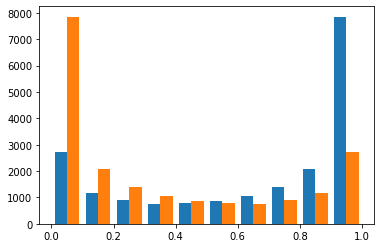

In [222]:
plt.hist(Pred_Prob)

In [223]:
np.linspace(96,100,5)

array([ 96.,  97.,  98.,  99., 100.])

In [224]:
15000*.03

450.0

In [225]:
np.percentile(Pred_Prob[:,1],np.linspace(96,100,5))

array([0.98295228, 0.98692463, 0.99093077, 0.9950192 , 0.99934548])

In [226]:
pd.DataFrame({'perc':list(np.linspace(0,100,21)),'Value':np.percentile(Pred_Prob[:,1],np.linspace(0,100,21))})

,perc,Value
0,0.0,7.839064e-09
1,5.0,4.529093e-04
2,10.0,1.912404e-03
3,15.0,4.881016e-03
4,20.0,1.026997e-02
5,25.0,1.936055e-02
6,30.0,3.537151e-02
7,35.0,6.197591e-02
8,40.0,9.900438e-02
9,45.0,1.428039e-01


In [227]:
df_temp=pd.DataFrame(df_aggregated_inserted.groupby('SAVM_GROUP_ID')['year_quarter'].max())
df_temp.reset_index(inplace=True)

In [228]:
df_temp_2=df_aggregated_inserted.merge(df_temp,how='inner',on=['SAVM_GROUP_ID','year_quarter'])

In [229]:
df_temp_2['Predictions'] = pd.DataFrame(y_pred)

In [230]:
df_temp_2['Predictions'].value_counts()

0.0    13279
1.0     6304
Name: Predictions, dtype: int64

In [231]:
Pred_Prob[:,1]

array([0.03756938, 0.45341128, 0.75018823, ..., 0.05536629, 0.6316826 ,
       0.00279734], dtype=float32)

In [232]:
df_temp_2['Prob'] = pd.DataFrame(Pred_Prob[:,1]*100)

In [233]:
df_temp_2[df_temp_2['Prob']>0.5].shape

(16616, 73)

In [234]:
df_temp_2['Predictions'].isnull().sum()

256

In [235]:
df_temp_2.dropna(inplace=True)

In [236]:
df_temp_2.shape

(19583, 73)

In [237]:
df_temp_2

,SAVM_GROUP_ID,year_quarter,Vert_Education- Public/Private,Vert_Energy/Utilities,Vert_Financial Services,Vert_Government,Vert_Health Care,Vert_Hospitality/Hotels & Leisure,Vert_Manufacturing,Vert_Media/Entertainment,...,BEval_SP Video Infrastructure,BEval_SP Video Software and Solutions,BEval_Security,BEval_Service Provider Routing,BEval_Services ASS_L1,BEval_Services TSS_L1,BEval_UNKNOWN,BEval_Wireless,Predictions,Prob
0,203684844,202003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1757043.0,0.0,0.0,0.0,3.756938
1,203684845,202003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,125234.0,0.0,0.0,4716984.0,0.0,0.0,0.0,45.341129
2,203684846,202003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3487492.0,74587.0,0.0,3357083.0,0.0,2918853.0,1.0,75.018822
3,203684847,202003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,566474.0,202898.0,714740.0,5852036.0,0.0,0.0,0.0,6.094367
4,203684848,202003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,208842.0,0.0,6126419.0,0.0,1033090.0,0.0,22.581158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19578,283471757,202003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,198795.0,880280.0,0.0,118254.0,0.0,1.536329
19579,283472189,202003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,106158.0,6285215.0,1727609.0,420062.0,0.0,7687.0,0.0,27.346092
19580,283472190,202003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.536629
19581,283472977,202003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,199127.0,0.0,5714.0,1.0,63.168259


In [238]:
df_temp_2.to_csv('datacenter_Propensity.csv')